# Data Preprocessing

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, confusion_matrix

import re
import datetime

2023-12-20 22:07:12.935602: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 22:07:12.965444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 22:07:13.190109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-20 22:07:13.191492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 22:07:14.320814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Read Data

In [2]:
# The data that contains the movieId, imdbId, and tmdbId
links = pd.read_csv("ml-latest-small/links.csv")
# The data that contains the movieId, title, and genres
movies = pd.read_csv("ml-latest-small/movies.csv")
# The data that contains the userId, movieId, rating, and timestamp
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# The data that contains the userId, movieId, tag, and timestamp
tags = pd.read_csv("ml-latest-small/tags.csv")

Prepare dataset

In [3]:
# Merge tags and ratings
tags_ratings = pd.merge(tags, ratings, on=['userId','movieId'], how='outer', suffixes=('_tags', ' '))
# # Drop columns that contain _rating
tags_ratings = tags_ratings.drop(columns=['timestamp_tags'])

# Merge tags_ratings and movies
data = pd.merge(tags_ratings, movies, on=['movieId'], how='outer', suffixes=(' ', '_movie'))
# Rename timestamp column as timestamp
data = data.rename(columns={'timestamp ': 'timestamp'})
# Change column order
data = data[["movieId","userId", "title", "rating","genres" ,"tag","timestamp"]]
# Drop rows with NaN timestamp
data = data.dropna(subset=["timestamp"])
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data["timestamp"] = data['timestamp'].astype('datetime64[ns]')

In [4]:
# Relabel ratings to 1 and 0
data['rating'] = data['rating'].apply(lambda x: 1 if x > 3 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x) if x is not np.nan else np.nan)
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x) if x is not np.nan else np.nan)
# Convert to lowercase
data['tag'] = data['tag'].str.lower()

# Model Development

In [5]:
# Drop rows with NaN tag
filled_tags = data.dropna(subset=['tag'])
# Initialize tokenizer
tokenizer = Tokenizer()
# Fit on tags
tokenizer.fit_on_texts(filled_tags['tag'])
# Create sequences
sequences = tokenizer.texts_to_sequences(filled_tags['tag'])
# Find number of unique tokens
word_index = tokenizer.word_index
# Print length number of unique tokens
print('Found %s unique tokens.' % len(word_index))
# Pad sequences
pseq = pad_sequences(sequences)
# Convert to dataframe
pdseq = pd.DataFrame(pseq)

Found 1730 unique tokens.


In [6]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
# Fit and transform corpus
corpus = filled_tags['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
# Convert to array
wordvec = wordvec.toarray()
# Get words
words = vectorizer.get_feature_names_out()
# Print number of words
print("number of words in plot summary: ", len(words))
# Convert to dataframe
pdwordvec = pd.DataFrame(wordvec,columns=words)

number of words in plot summary:  1657


In [7]:
# Initialize a dictionary to store the embeddings
embeddings_index = {}
# Open the file
f = open('glove.6B.100d.txt')
# Loop through each line
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
# Close the file
f.close()
# Print the number of words found
print('Found %s word vectors.' % len(embeddings_index))
# Initialize embedding matrix
embedding_matrix = np.zeros((len(words), 100))
# Loop through each word
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
# Convert to dataframe
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


## K-Means

In [8]:
# Apply PCA
reduced_data = PCA(n_components=2).fit_transform(pdembedding.T)
# Initialize KMeans
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
# Fit the kmeans object with the reduced data
kmeans.fit(reduced_data)

# Step size of the mesh.
h = .02

# Arrange grid points
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

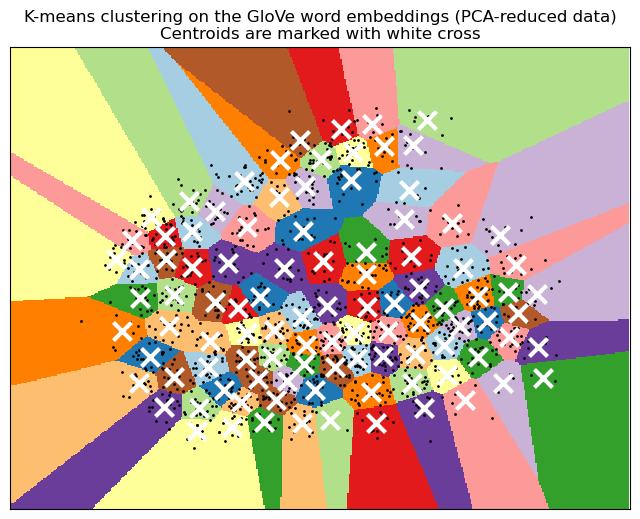

In [9]:
plt.figure(figsize=(8, 6))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

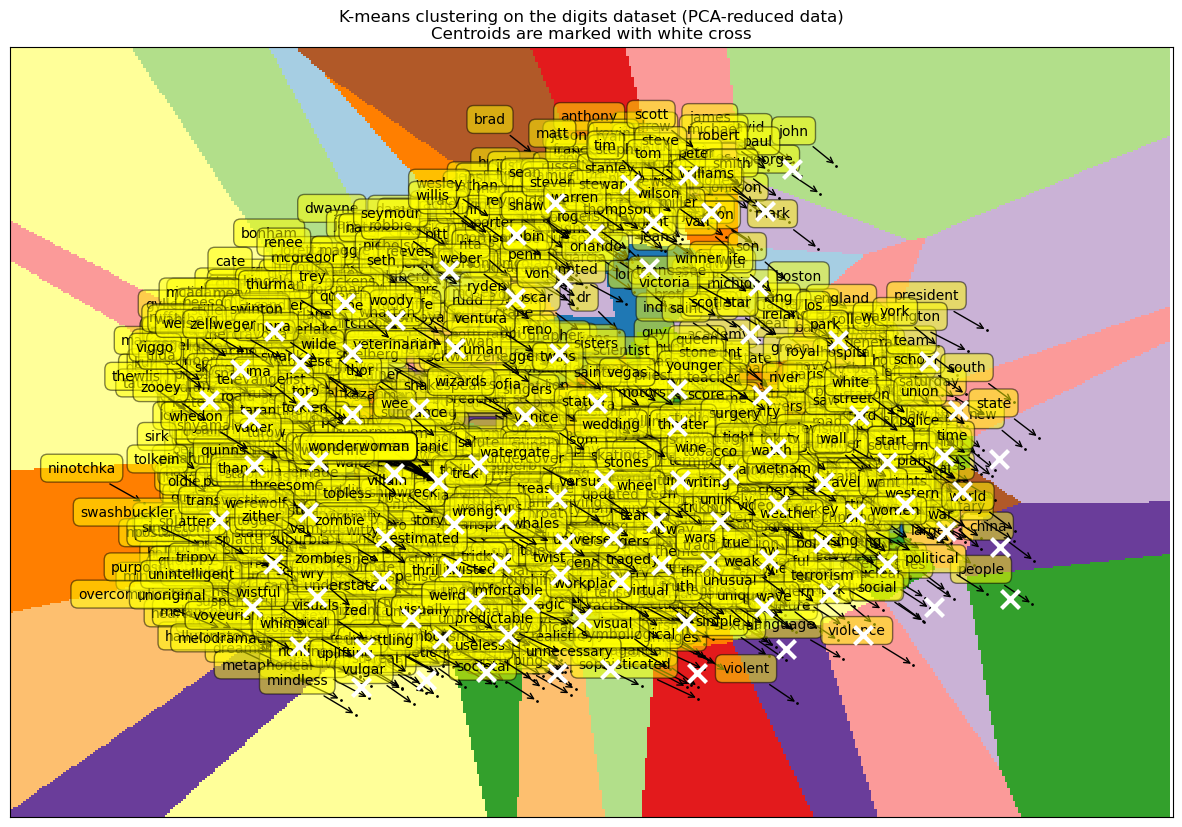

In [10]:
plt.figure(figsize=(15, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Random Forest

In [11]:
# Cluster word embeddings data
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
# Fit kmeans object to word embeddings data
kmeans.fit(pdwordvec.T)
# Get cluster labels
clusters = kmeans.labels_


# Create a dictionary to store columns for each cluster
cluster_columns = {str(i): [0] * len(data) for i in range(max(clusters) + 1)}

# Update the dictionary values based on word-cluster associations
for i, column in enumerate(pdwordvec.columns):
    indices = pdwordvec.index[pdwordvec[column] > 0]
    cluster_columns[str(clusters[i])] = [1 if idx in indices else val for idx, val in enumerate(cluster_columns[str(clusters[i])])]

# Create a DataFrame from the cluster columns dictionary
cluster_df = pd.DataFrame(cluster_columns)

# Concatenate the cluster columns to the 'data' DataFrame
data = pd.concat([data, cluster_df], axis=1)

In [12]:
#Drop tag as we will use vectorized words
# data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Reset index of genresplit
genresplit = genresplit.reset_index()

#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Joın data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)

# Fill NaN values with with np.nan
data = data.fillna(np.nan)
# Drop rows with NaN title
data = data.dropna(subset=["title"])

## ML Classification Models

In [13]:
# Split data into train and test
train = data[(data['timestamp'] < '2017-05-01') ]
test = data[(data['timestamp'] >= '2017-05-01') ]

# Print lengths of train and test data
print("len test data set:", len(test))
print("len training data set:",len(train))

len test data set: 13502
len training data set: 89175


In [14]:
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating','genres','tag','timestamp','title'], axis=1)
x_test = test.drop(['rating','genres','tag','timestamp','title'], axis=1)

# Fill null values with 0
x_train.fillna(0, inplace=True)
# Fill null values with 0
x_test.fillna(0, inplace=True)

### Logistic Regression

In [ ]:
logreg = LogReg(C = 1, class_weight='balanced')
logreg.fit (x_train, y_train)
y_predlog = logreg.predict_proba(x_test)
R2_log = logreg.score(x_test,y_test) 
print("Accuracy of the test set for log. reg. is: ", np.round(R2_log,2))

### Random Forest

In [ ]:
# Initialize Random Forest Classifier
RFC = RandomForestClassifier(class_weight='balanced')
# Set parameters of Random Forest Classifier
RFC.set_params(n_estimators=10)
# Fit the model
RFC.fit(x_train, y_train)
# Predict on test data
y_pred = RFC.predict(x_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Accuracy, recall, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy",np.round(accuracy, 2))
print("\nRecall: ", np.round(recall, 2))
print("Precision: ", np.round(precision, 2))
print("F1 Score: ", np.round(f1, 2))

In [ ]:
# Feature importance of Random Forest Classifier
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)

userid_298.0        0.057162
userid_307.0        0.044990
userid_19.0         0.031233
userid_217.0        0.027339
userid_368.0        0.022506
                      ...   
movieid_6162.0      0.000000
movieid_6159.0      0.000000
movieid_6158.0      0.000000
movieid_6156.0      0.000000
movieid_193609.0    0.000000
Name: Importance, Length: 10653, dtype: float64